In [1]:
import numpy as np
import pandas as pd
import os
import sys

### Đọc dữ liệu

In [2]:
daily_df = pd.read_csv("../data/strategy_04.csv")
monthly_df = pd.read_csv("../data/strategy_04_monthly.csv")

In [4]:
daily_df.head(2)

,d,revenue,cnt_cus,cnt_pro,cnt
0,2010-12-01,58635.56,98.0,1351.0,26814.0
1,2010-12-02,46207.28,117.0,934.0,21023.0


In [6]:
monthly_df.head(2)

,m,revenue,cnt_cus,cnt_pro,cnt
0,2010-12-01,748957.02,948,2822,342228
1,2011-01-01,560000.26,783,2645,308966


In [7]:
daily_df = daily_df.sort_values("d")

In [9]:
daily_df.columns

Index(['d', 'revenue', 'cnt_cus', 'cnt_pro', 'cnt'], dtype='object')

### Phân tích

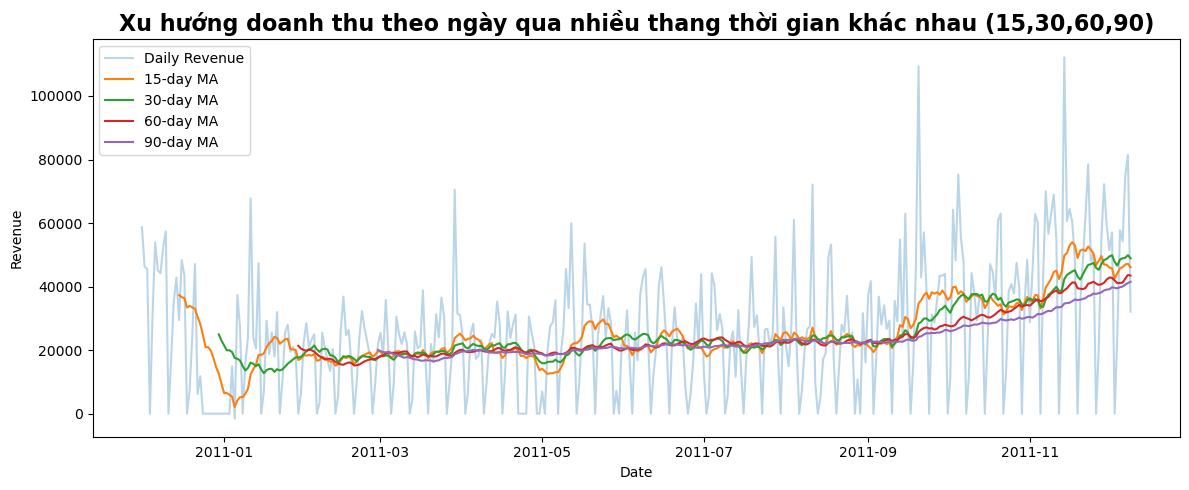

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# đảm bảo cột ngày đúng kiểu
daily_df['d'] = pd.to_datetime(daily_df['d'])

# tính các moving averages
daily_df['ma15'] = daily_df['revenue'].rolling(window=15).mean()
daily_df['ma30'] = daily_df['revenue'].rolling(window=30).mean()
daily_df['ma60'] = daily_df['revenue'].rolling(window=60).mean()
daily_df['ma90'] = daily_df['revenue'].rolling(window=90).mean()

plt.figure(figsize=(12, 5))

# dữ liệu gốc
sns.lineplot(
    data=daily_df,
    x='d',
    y='revenue',
    label='Daily Revenue',
    alpha=0.3
)

# các baseline trend theo nhiều scale
sns.lineplot(data=daily_df, x='d', y='ma15', label='15-day MA')
sns.lineplot(data=daily_df, x='d', y='ma30', label='30-day MA')
sns.lineplot(data=daily_df, x='d', y='ma60', label='60-day MA')
sns.lineplot(data=daily_df, x='d', y='ma90', label='90-day MA')

# tiêu đề kể chuyện
plt.title(
    'Xu hướng doanh thu theo ngày qua nhiều thang thời gian khác nhau (15,30,60,90)',
    fontsize=16,
    fontweight="bold"
)

plt.xlabel('Date')
plt.ylabel('Revenue')
plt.legend()
plt.tight_layout()
plt.show()


#### Kiểm tra bằng OLS model

In [17]:
import statsmodels.api as sm
daily_df['d'] = pd.to_datetime(daily_df['d'])
daily_df = daily_df.sort_values('d')
daily_df['t'] = range(len(daily_df))
X = sm.add_constant(daily_df['t'])
y = daily_df['revenue']
model = sm.OLS(y, X).fit()
print(f"p-value = {model.pvalues['t']}")
print(model.summary())

p-value = 1.7714564138409484e-12
                            OLS Regression Results                            
Dep. Variable:                revenue   R-squared:                       0.125
Model:                            OLS   Adj. R-squared:                  0.123
Method:                 Least Squares   F-statistic:                     53.27
Date:                Sun, 04 Jan 2026   Prob (F-statistic):           1.77e-12
Time:                        23:13:22   Log-Likelihood:                -4209.6
No. Observations:                 374   AIC:                             8423.
Df Residuals:                     372   BIC:                             8431.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.383e+

p-value < 0.05 --> Có trend --> Muốn tính seasonality thì phải khử trend trước.

t > 0: trend tăng.

#### Mann–Kendall Trend Test

In [20]:
!pip install pymannkendall

In [21]:
import pymannkendall as mk

result = mk.original_test(daily_df['revenue'])

print(result)

Mann_Kendall_Test(trend='increasing', h=True, p=1.1555867374113404e-11, z=6.785659089093483, Tau=0.23427621109374777, s=16341.0, var_s=5798558.333333333, slope=63.969448275862064, intercept=13075.517896551724)


#### Khử trend

In [22]:
import statsmodels.api as sm
daily_df = daily_df.sort_values('d')
daily_df['t'] = range(len(daily_df))

X = sm.add_constant(daily_df['t'])
y = daily_df['revenue']

model = sm.OLS(y, X).fit()

daily_df['trend_ols'] = model.predict(X)

daily_df['rev_detrended'] = daily_df['revenue'] - daily_df['trend_ols']

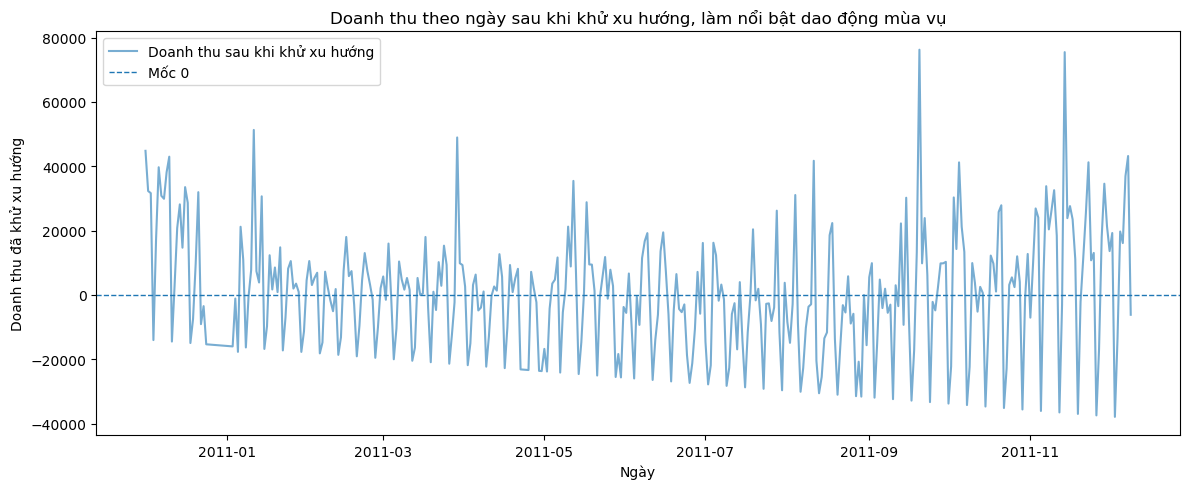

In [24]:
plt.figure(figsize=(12, 5))

sns.lineplot(
    data=daily_df,
    x='d',
    y='rev_detrended',
    label='Doanh thu sau khi khử xu hướng',
    alpha=0.6
)

# baseline = 0
plt.axhline(0, linestyle='--', linewidth=1, label='Mốc 0')

plt.title(
    'Doanh thu theo ngày sau khi khử xu hướng, làm nổi bật dao động mùa vụ',
    fontsize=12
)

plt.xlabel('Ngày')
plt.ylabel('Doanh thu đã khử xu hướng')
plt.legend()
plt.tight_layout()
plt.show()


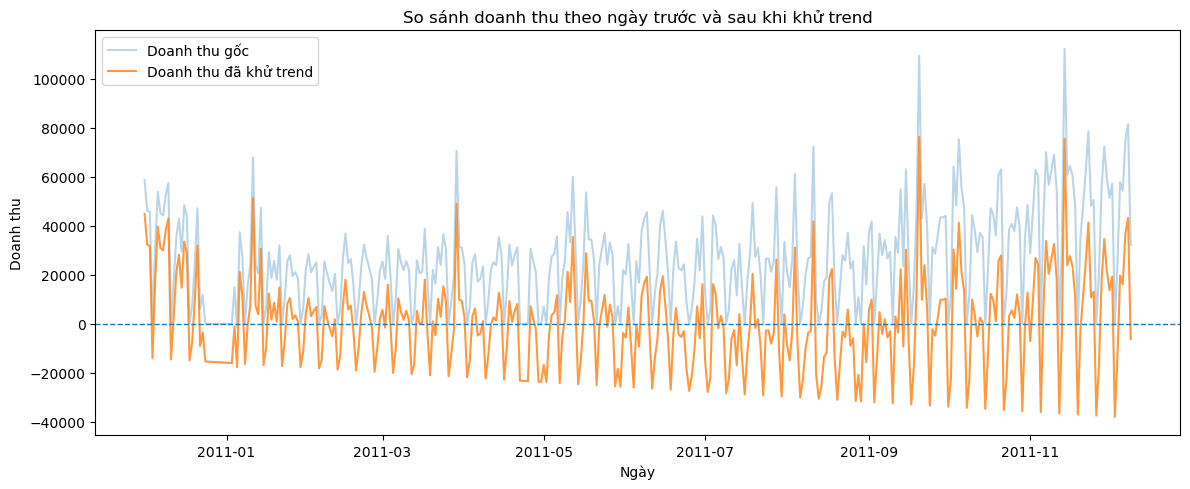

In [26]:
plt.figure(figsize=(12, 5))

sns.lineplot(
    data=daily_df,
    x='d',
    y='revenue',
    label='Doanh thu gốc',
    alpha=0.3
)

sns.lineplot(
    data=daily_df,
    x='d',
    y='rev_detrended',
    label='Doanh thu đã khử trend',
    alpha=0.8
)

plt.axhline(0, linestyle='--', linewidth=1)

plt.title(
    'So sánh doanh thu theo ngày trước và sau khi khử trend',
    fontsize=12
)

plt.xlabel('Ngày')
plt.ylabel('Doanh thu')
plt.legend()
plt.tight_layout()
plt.show()